In [1]:
# from google.colab import drive
# drive.mount('/content/drive')

In [32]:
import pandas as pd
from sklearn.svm import LinearSVC
from sklearn.svm import SVR
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split, cross_val_score 
from sklearn.feature_selection import SelectFromModel
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.datasets import load_iris
from sklearn.feature_selection import SelectFromModel
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report
from sklearn.preprocessing import StandardScaler, MinMaxScaler
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, r2_score
from xgboost.sklearn import XGBRegressor
import numpy as np
from sklearn.cluster import DBSCAN



pd.set_option('display.max_columns', 500)
pd.set_option('display.max_rows', 100)

Read data:

In [43]:
X_train = pd.read_pickle("X_train.pkl")
X_test = pd.read_pickle("X_test.pkl")
y_train = pd.read_pickle("y_train.pkl")
y_test = pd.read_pickle("y_test.pkl")

Delete non-numeric columns:

In [44]:
del X_train['joke_x']
del X_train['joke_tokenized']
del X_train['joke_text_processed']
del X_train['joke_processed_tokenized']
del X_train['joke_processed_tokenized_stemmed']
del X_train['joke_processed_tokenized_stemmed_str']
# del X_train['joke_embbedings']
del X_test['joke_x']
del X_test['joke_tokenized']
del X_test['joke_text_processed']
del X_test['joke_processed_tokenized']
del X_test['joke_processed_tokenized_stemmed']
del X_test['joke_processed_tokenized_stemmed_str']
# del X_test['joke_embbedings']

In [45]:
# Remove skew
def remove_skew_95(X,y,mean = None,std = None):
    if not mean:
        mean = y.mean()
    if not std:
        std = y.std()
    X = X[(y > (mean-2*std)) & (y < (mean+2*std))]
    y = y[(y > (mean-2*std)) & (y < (mean+2*std))]
    return X,y

In [46]:
mean = y_train.mean()
std = y_train.std()

In [47]:
X_train,y_train = remove_skew_95(X_train,y_train,mean,std)
X_test,y_test = remove_skew_95(X_test,y_test,mean,std)

In [48]:
X_train

,ambiguous_words,best_score_similarity_words,antonyms,longest_word,speical_chars,CARDINAL,DATE,EVENT,FAC,GPE,LANGUAGE,LAW,LOC,MONEY,NORP,ORDINAL,ORG,PERCENT,PERSON,PRODUCT,QUANTITY,TIME,WORK_OF_ART,ADJ,ADP,ADV,AUX,CCONJ,DET,INTJ,NOUN,NUM,PART,PRON,PROPN,PUNCT,SCONJ,SPACE,SYM,VERB,X,total_words,total_chars,breaking,bee,dead,used,sentence,black,man,black man,difference,pakistani,school,know,fly,drone,trump,like,australian,middle,people,worry,drinking,shower,sign,water,beer,say,wanted,christmas,wanna,rock,dad,today,son,actually,boring,little,cunt,year,cat,bar,looking,shot,common,real,number,new,movie,called,vladimir,putin,russian,door,asshole,donald,vladimir putin,donald trump,die,heart,going,trying,funeral,said,shall,wear,really,care,mum,long,stick,easy,tell,joke_y,midget,honey,short,tell joke,clinton,getting,video,game,left,claim,asked,stand,started,reply,true,story,human,hate,ca,nt,anymore,fence,ca nt,eye,doctor,thought,saw,turned,best,control,sad,stood,took,test,matter,free,tonight,old,somebody,fucking,year old,terrorist,tree,invisible,telling,jesus,supposed,want,sent,mexico,wall,guy,happy,upset,canadian,mexican,american,porn,popular,apparently,recently,got,internet,cross,hell,come,fuck,wish,life,cut,life like,walk,edit,walk bar,forgot,throw,came,start,foot,time,odd,told,lady,sort,wife,valentine,day,treat,princess,killed,accident,wife wanted,valentine day,hand,bunch,change,use,coffee,right,original,place,ship,worst,kitchen,sink,ended,relationship,okay,worried,thing,tomorrow,record,song,law,yeast,make,went,mean,learned,hear,arrested,yesterday,charged,rabbit,head,look,look like,way,touch,self,single,toilet,paper,money,irish,...,massacre,bowling green,religious,cop,comment,potato,government,mother law,political,feed,area,knew,tried,room,angry,violence,mosquito,student,recent,extra,longer,bar bartender,indian,bit,removed,bird,opposite,nun,pregnant,deaf,math,punch,falcon,degree,realized,11,miss,known,period,pain,prison,theory,dildo,light,buddhist,past,addicted,night,college,grandpa,ground,king,quite,travel,cabinet,dark,change lightbulb,truck,fired,meat,bos,driver,weird,giant,mushroom,bread,needed,grow,yeah,direction,minute,silver,bag,ok,racist,apple,vegetable,window,user,cancer,cock,morning,laughed,patriot,act,michael,race,marriage,husband,fine,talking,mouse,crazy,bannon,helen,forget,view,month,write,violet blue,chemist,play,british,boo,atlanta,atlanta falcon,ring,spanish,check,walked,waiting,reason,entire,large,sound,decided,daughter,gas,bond,caught,camp,tired,river,sir,police officer,dy,player,fart,team,cheese,language,clock,biggest,laugh,wearing,trash,apart,mr,wife told,skin,bulb,change light,light bulb,super,aunt,cell,step,bowl,super bowl,grammar,sheep,stole,vagina,flying,twin,tower,married,butt,accidentally,waiter,poor,fun,product,hooker,laid,bring,soccer,bible,singer,beef,letter,expected,pussy,brother,sorry,rooster,war,isi,potassium,asking,tv,buck,group,rest,silly,finished,scientist,bell,alphabet,street,size,knife,leaf,responds,wheelchair,lawyer,rate,priest,restaurant,wine,dream,100,present,art,lord,organ,40,pull,mirror,bet,brady,building,attractive,fan,bar say,late,walked bar,fight,park,dude,dyslexic,mile,travelling,build,putting,nfl,op,grandma,breaking news,scottish,iphone,smoke,psychiatrist,responded,deep,uncle,anal,donkey,alcohol,shoot,watching,pulled,pound,fast,answer,root,wrong sub,quit,unfortunately,trump president
4227,3,0.780035,0,10,3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,0,0,1,0,1,0,0,1,1,1,0,0,0,1,0,16,81,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,N

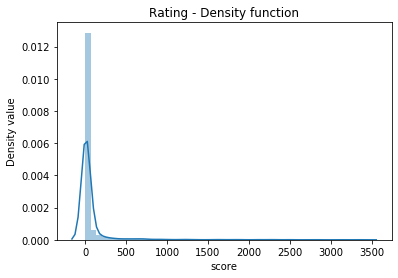

In [49]:
# Feature scaling and outliers removal
ax = sns.distplot(y_train);
ax.set_title('Rating - Density function');
ax.set_ylabel('Density value');
plt.show();

In [50]:
X_train.fillna(0,inplace=True)
X_test.fillna(0,inplace=True)

In [51]:
y_train

4227     49
1415     43
1907     11
3508      5
3685      8
       ... 
1433     13
1636    214
1093     52
4440    150
4019     10
Name: score, Length: 3131, dtype: int64

In [52]:
y_train_arr = np.array(y_train).reshape(-1,1)
scaler = MinMaxScaler()
scaler.fit(np.array(y_train_arr))
y_train = pd.Series(scaler.transform(y_train_arr).reshape(-1,))
y_test = pd.Series(scaler.transform(y_train_arr).reshape(-1,))

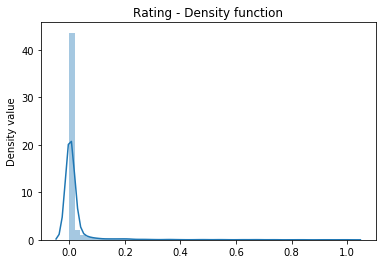

In [53]:
# Feature scaling and outliers removal
ax = sns.distplot(y_train);
ax.set_title('Rating - Density function');
ax.set_ylabel('Density value');
plt.show();

In [57]:
scaler = MinMaxScaler()
scaler.fit(X_train[['total_chars']])
X_train['total_chars'] = scaler.transform(X_train[['total_chars']])
X_test['total_chars'] = scaler.transform(X_test[['total_chars']])

In [58]:
scaler = MinMaxScaler()
scaler.fit(X_train[['total_words']])
X_train['total_words'] = scaler.transform(X_train[['total_words']])
X_test['total_words'] = scaler.transform(X_test[['total_words']])

In [87]:
from sklearn.cluster import KMeans
kmeans = KMeans(n_clusters=500, random_state=0).fit(X_train)

In [88]:
kmeans.inertia_

8634.907784523677

In [78]:
kmeans.predict(X_test)

array([0, 4, 0, 0, 0, 3, 0, 2, 0, 0, 2, 2, 0, 2, 2, 2, 4, 0, 3, 2, 2, 2,
       4, 0, 4, 2, 2, 0, 0, 4, 2, 0, 0, 2, 2, 2, 0, 2, 2, 2, 2, 0, 2, 0,
       0, 0, 4, 0, 2, 0, 2, 0, 0, 2, 2, 2, 2, 0, 4, 2, 0, 4, 2, 0, 2, 4,
       2, 0, 2, 0, 2, 4, 2, 0, 0, 4, 4, 0, 2, 0, 4, 0, 0, 0, 0, 0, 2, 0,
       4, 0, 2, 0, 4, 0, 2, 0, 2, 0, 4, 4, 4, 4, 2, 0, 2, 0, 0, 2, 0, 0,
       0, 2, 4, 2, 2, 2, 2, 0, 2, 2, 2, 0, 2, 2, 2, 2, 0, 0, 0, 4, 0, 2,
       2, 2, 2, 2, 0, 0, 4, 0, 0, 4, 0, 2, 4, 0, 2, 0, 2, 2, 0, 0, 2, 0,
       4, 2, 0, 0, 2, 0, 0, 0, 2, 0, 0, 3, 2, 0, 2, 2, 2, 2, 2, 2, 0, 0,
       2, 0, 0, 0, 0, 3, 2, 0, 0, 2, 2, 0, 2, 3, 0, 0, 0, 0, 0, 0, 2, 0,
       0, 2, 2, 0, 4, 2, 2, 4, 2, 2, 0, 2, 2, 2, 0, 0, 2, 2, 2, 0, 0, 0,
       2, 4, 0, 2, 0, 2, 2, 0, 2, 4, 0, 2, 0, 0, 0, 2, 4, 4, 0, 0, 0, 2,
       4, 2, 2, 0, 2, 2, 2, 4, 4, 0, 2, 3, 2, 4, 2, 0, 3, 0, 2, 0, 2, 0,
       2, 3, 2, 4, 4, 4, 2, 0, 3, 0, 2, 0, 2, 2, 0, 2, 0, 0, 2, 4, 2, 0,
       4, 4, 0, 2, 0, 0, 2, 2, 0, 3, 2, 0, 0, 2, 0,

In [67]:
clustering.labels_[:500]

array([ 0,  0, -1, -1,  0,  0,  0,  0,  0,  0, -1,  0, -1,  0,  0,  0, -1,
        0,  0,  0,  0,  0,  0,  0,  0,  0, -1, -1, -1, -1,  0,  0,  0,  0,
        0,  0,  0, -1,  0, -1, -1, -1,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0, -1, -1, -1,  0,  0,  0,  0,  0,  0, -1, -1,  0,  0,  0,  0,  0,
        0,  0, -1,  0,  0,  0, -1,  0,  0,  0,  0,  0,  0, -1,  0,  0,  0,
        0, -1,  0, -1,  0, -1,  0,  0,  0,  0, -1, -1, -1,  0,  0,  0, -1,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0, -1,  0,
        0,  0,  0, -1,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0, -1,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0, -1,  0, -1,  0, -1,  0,  0,
        0,  0,  0,  0, -1,  0,  0,  0,  0,  0,  0,  0, -1, -1,  0, -1,  0,
        0,  0,  0,  0, -1,  0,  0, -1,  0,  0,  0,  0, -1,  0,  0,  0, -1,
        0, -1,  0,  0,  0,  0,  0,  0, -1,  0,  0,  0,  0,  0, -1,  0,  0,
       -1,  0,  0,  0,  0,  0,  0,  0,  0, -1,  0,  0,  0,  0,  0,  0,  0,
       -1,  0, -1,  0, -1

Baseline prediction:

In [38]:
y_baseline = np.full(y_test.shape,y_train.mean())
print(f'{np.sqrt(mean_squared_error(y_test, y_baseline))}')

2475.1320400324225


**Linear Regression (Normalized)**

In [ ]:
from sklearn.linear_model import LinearRegression
reg = LinearRegression(normalize=True).fit(X_train, y_train)
y_pred_lin_reg_norm = reg.predict(X_test)

In [32]:
print(f'{np.sqrt(mean_squared_error(y_test, y_pred_lin_reg_norm))}')

2706.59386415386


**Linear Regression (Un-Normalized)**

In [33]:
from sklearn.linear_model import LinearRegression
reg = LinearRegression(normalize=False).fit(X_train, y_train)
y_pred_lin_reg = reg.predict(X_test)
print(f'{np.sqrt(mean_squared_error(y_test, y_pred_lin_reg))}')

2704.672332105507


**ElasticNet**

In [50]:
from sklearn.linear_model import ElasticNet
from sklearn.model_selection import RandomizedSearchCV

# Use randomized search to tune the parameters:

params = {"l1_ratio": np.arange(0,1.01,0.05),
                  "alpha": [0.00001,0.00003,0.0001,0.0003,0.001,0.003,0.01,0.03,0.1,0.3,1,3,10,30,100,300],
                  "warm_start": [True,False],
                  "selection": ['random', 'cyclic']}

eNet = ElasticNet()
elastic_net_rnd = RandomizedSearchCV(eNet, params, scoring='r2',
                                     n_jobs = -1, verbose = 2)
elastic_net_rnd.fit(X_train, y_train)
y_pred_elasticnet = elastic_net_rnd.predict(X_test)

Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:  2.9min
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:  3.8min finished
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 6971495899.546175, tolerance: 1508604.589125975
  positive)


In [53]:
print(f'{np.sqrt(mean_squared_error(y_test, y_pred_elasticnet))}')

2470.5143802122384


**Random Forest Regressor**

In [55]:
# Create the parameter grid based on the results of random search 
# Consider using tree pruning
rf = RandomForestRegressor()
params = {
    'bootstrap': [True],
    'max_depth': np.arange(2,50,7),
    'max_features': np.arange(5,115,10),
    'min_samples_leaf': np.arange(2,10,1),
    'min_samples_split': np.arange(2,70,5),
    'n_estimators': [100, 200, 300, 1000]
}
rnd_forest_src = RandomizedSearchCV(rf, params, scoring='r2', n_jobs = -1, verbose = 2)

# Fit the grid search to the data
rnd_forest_src.fit(X_train, y_train)
print(rnd_forest_src.best_params_)
best_grid = rnd_forest_src.best_estimator_
y_pred_rnd_forest = rnd_forest_src.predict(X_test)
print(f'{np.sqrt(mean_squared_error(y_test, y_pred_rnd_forest))}')

Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed: 21.2min
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed: 23.8min finished


{'n_estimators': 100, 'min_samples_split': 67, 'min_samples_leaf': 8, 'max_features': 25, 'max_depth': 65, 'bootstrap': True}
2481.08152976768


**XGBoost Regressor**

In [60]:
# Various hyper-parameters to tune
xgb = XGBRegressor()
params = {'objective':['reg:squarederror'],
              'learning_rate': [0.001,0.003,0.01,0.03,0.1,0.3,1,3,10],
              'max_depth': np.arange(2,50,7),
              'subsample': [1], # Reduce to prevent overfitting
              'colsample_bytree': [1]} # Reduct to prevent overfitting

xgb_rnd = RandomizedSearchCV(xgb, params, scoring='r2', verbose = 0)

xgb_rnd.fit(X_train,y_train)

print(xgb_rnd.best_score_)
print(xgb_rnd.best_params_)

Fitting 5 folds for each of 10 candidates, totalling 50 fits
[CV] subsample=1, objective=reg:squarederror, max_depth=30, learning_rate=3, colsample_bytree=1 


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
/usr/local/lib/python3.6/dist-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[CV]  subsample=1, objective=reg:squarederror, max_depth=30, learning_rate=3, colsample_bytree=1, total=  49.6s
[CV] subsample=1, objective=reg:squarederror, max_depth=30, learning_rate=3, colsample_bytree=1 


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   49.6s remaining:    0.0s
/usr/local/lib/python3.6/dist-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[CV]  subsample=1, objective=reg:squarederror, max_depth=30, learning_rate=3, colsample_bytree=1, total=  59.8s
[CV] subsample=1, objective=reg:squarederror, max_depth=30, learning_rate=3, colsample_bytree=1 


/usr/local/lib/python3.6/dist-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[CV]  subsample=1, objective=reg:squarederror, max_depth=30, learning_rate=3, colsample_bytree=1, total=  56.7s
[CV] subsample=1, objective=reg:squarederror, max_depth=30, learning_rate=3, colsample_bytree=1 


/usr/local/lib/python3.6/dist-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[CV]  subsample=1, objective=reg:squarederror, max_depth=30, learning_rate=3, colsample_bytree=1, total=  60.0s
[CV] subsample=1, objective=reg:squarederror, max_depth=30, learning_rate=3, colsample_bytree=1 


/usr/local/lib/python3.6/dist-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[CV]  subsample=1, objective=reg:squarederror, max_depth=30, learning_rate=3, colsample_bytree=1, total=  55.8s
[CV] subsample=1, objective=reg:squarederror, max_depth=9, learning_rate=3, colsample_bytree=1 


/usr/local/lib/python3.6/dist-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[CV]  subsample=1, objective=reg:squarederror, max_depth=9, learning_rate=3, colsample_bytree=1, total=  17.8s
[CV] subsample=1, objective=reg:squarederror, max_depth=9, learning_rate=3, colsample_bytree=1 


/usr/local/lib/python3.6/dist-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[CV]  subsample=1, objective=reg:squarederror, max_depth=9, learning_rate=3, colsample_bytree=1, total=  18.8s
[CV] subsample=1, objective=reg:squarederror, max_depth=9, learning_rate=3, colsample_bytree=1 


/usr/local/lib/python3.6/dist-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[CV]  subsample=1, objective=reg:squarederror, max_depth=9, learning_rate=3, colsample_bytree=1, total=  13.9s
[CV] subsample=1, objective=reg:squarederror, max_depth=9, learning_rate=3, colsample_bytree=1 


/usr/local/lib/python3.6/dist-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[CV]  subsample=1, objective=reg:squarederror, max_depth=9, learning_rate=3, colsample_bytree=1, total=  17.7s
[CV] subsample=1, objective=reg:squarederror, max_depth=9, learning_rate=3, colsample_bytree=1 


/usr/local/lib/python3.6/dist-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[CV]  subsample=1, objective=reg:squarederror, max_depth=9, learning_rate=3, colsample_bytree=1, total=  18.4s
[CV] subsample=1, objective=reg:squarederror, max_depth=30, learning_rate=1, colsample_bytree=1 


/usr/local/lib/python3.6/dist-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[CV]  subsample=1, objective=reg:squarederror, max_depth=30, learning_rate=1, colsample_bytree=1, total=  30.5s
[CV] subsample=1, objective=reg:squarederror, max_depth=30, learning_rate=1, colsample_bytree=1 


/usr/local/lib/python3.6/dist-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[CV]  subsample=1, objective=reg:squarederror, max_depth=30, learning_rate=1, colsample_bytree=1, total=  31.0s
[CV] subsample=1, objective=reg:squarederror, max_depth=30, learning_rate=1, colsample_bytree=1 


/usr/local/lib/python3.6/dist-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[CV]  subsample=1, objective=reg:squarederror, max_depth=30, learning_rate=1, colsample_bytree=1, total=  30.5s
[CV] subsample=1, objective=reg:squarederror, max_depth=30, learning_rate=1, colsample_bytree=1 


/usr/local/lib/python3.6/dist-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[CV]  subsample=1, objective=reg:squarederror, max_depth=30, learning_rate=1, colsample_bytree=1, total=  30.2s
[CV] subsample=1, objective=reg:squarederror, max_depth=30, learning_rate=1, colsample_bytree=1 


/usr/local/lib/python3.6/dist-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[CV]  subsample=1, objective=reg:squarederror, max_depth=30, learning_rate=1, colsample_bytree=1, total=  30.7s
[CV] subsample=1, objective=reg:squarederror, max_depth=30, learning_rate=0.3, colsample_bytree=1 


/usr/local/lib/python3.6/dist-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[CV]  subsample=1, objective=reg:squarederror, max_depth=30, learning_rate=0.3, colsample_bytree=1, total= 1.8min
[CV] subsample=1, objective=reg:squarederror, max_depth=30, learning_rate=0.3, colsample_bytree=1 


/usr/local/lib/python3.6/dist-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[CV]  subsample=1, objective=reg:squarederror, max_depth=30, learning_rate=0.3, colsample_bytree=1, total= 1.8min
[CV] subsample=1, objective=reg:squarederror, max_depth=30, learning_rate=0.3, colsample_bytree=1 


/usr/local/lib/python3.6/dist-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[CV]  subsample=1, objective=reg:squarederror, max_depth=30, learning_rate=0.3, colsample_bytree=1, total= 1.8min
[CV] subsample=1, objective=reg:squarederror, max_depth=30, learning_rate=0.3, colsample_bytree=1 


/usr/local/lib/python3.6/dist-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[CV]  subsample=1, objective=reg:squarederror, max_depth=30, learning_rate=0.3, colsample_bytree=1, total= 1.8min
[CV] subsample=1, objective=reg:squarederror, max_depth=30, learning_rate=0.3, colsample_bytree=1 


/usr/local/lib/python3.6/dist-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[CV]  subsample=1, objective=reg:squarederror, max_depth=30, learning_rate=0.3, colsample_bytree=1, total= 1.8min
[CV] subsample=1, objective=reg:squarederror, max_depth=23, learning_rate=0.003, colsample_bytree=1 


/usr/local/lib/python3.6/dist-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[CV]  subsample=1, objective=reg:squarederror, max_depth=23, learning_rate=0.003, colsample_bytree=1, total= 1.3min
[CV] subsample=1, objective=reg:squarederror, max_depth=23, learning_rate=0.003, colsample_bytree=1 


/usr/local/lib/python3.6/dist-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[CV]  subsample=1, objective=reg:squarederror, max_depth=23, learning_rate=0.003, colsample_bytree=1, total= 1.3min
[CV] subsample=1, objective=reg:squarederror, max_depth=23, learning_rate=0.003, colsample_bytree=1 


/usr/local/lib/python3.6/dist-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[CV]  subsample=1, objective=reg:squarederror, max_depth=23, learning_rate=0.003, colsample_bytree=1, total= 1.3min
[CV] subsample=1, objective=reg:squarederror, max_depth=23, learning_rate=0.003, colsample_bytree=1 


/usr/local/lib/python3.6/dist-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[CV]  subsample=1, objective=reg:squarederror, max_depth=23, learning_rate=0.003, colsample_bytree=1, total= 1.3min
[CV] subsample=1, objective=reg:squarederror, max_depth=23, learning_rate=0.003, colsample_bytree=1 


/usr/local/lib/python3.6/dist-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[CV]  subsample=1, objective=reg:squarederror, max_depth=23, learning_rate=0.003, colsample_bytree=1, total= 1.3min
[CV] subsample=1, objective=reg:squarederror, max_depth=30, learning_rate=0.001, colsample_bytree=1 


/usr/local/lib/python3.6/dist-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[CV]  subsample=1, objective=reg:squarederror, max_depth=30, learning_rate=0.001, colsample_bytree=1, total= 1.7min
[CV] subsample=1, objective=reg:squarederror, max_depth=30, learning_rate=0.001, colsample_bytree=1 


/usr/local/lib/python3.6/dist-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[CV]  subsample=1, objective=reg:squarederror, max_depth=30, learning_rate=0.001, colsample_bytree=1, total= 1.7min
[CV] subsample=1, objective=reg:squarederror, max_depth=30, learning_rate=0.001, colsample_bytree=1 


/usr/local/lib/python3.6/dist-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[CV]  subsample=1, objective=reg:squarederror, max_depth=30, learning_rate=0.001, colsample_bytree=1, total= 1.8min
[CV] subsample=1, objective=reg:squarederror, max_depth=30, learning_rate=0.001, colsample_bytree=1 


/usr/local/lib/python3.6/dist-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[CV]  subsample=1, objective=reg:squarederror, max_depth=30, learning_rate=0.001, colsample_bytree=1, total= 1.8min
[CV] subsample=1, objective=reg:squarederror, max_depth=30, learning_rate=0.001, colsample_bytree=1 


/usr/local/lib/python3.6/dist-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[CV]  subsample=1, objective=reg:squarederror, max_depth=30, learning_rate=0.001, colsample_bytree=1, total= 1.7min
[CV] subsample=1, objective=reg:squarederror, max_depth=16, learning_rate=1, colsample_bytree=1 


/usr/local/lib/python3.6/dist-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[CV]  subsample=1, objective=reg:squarederror, max_depth=16, learning_rate=1, colsample_bytree=1, total=  20.7s
[CV] subsample=1, objective=reg:squarederror, max_depth=16, learning_rate=1, colsample_bytree=1 


/usr/local/lib/python3.6/dist-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[CV]  subsample=1, objective=reg:squarederror, max_depth=16, learning_rate=1, colsample_bytree=1, total=  20.4s
[CV] subsample=1, objective=reg:squarederror, max_depth=16, learning_rate=1, colsample_bytree=1 


/usr/local/lib/python3.6/dist-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[CV]  subsample=1, objective=reg:squarederror, max_depth=16, learning_rate=1, colsample_bytree=1, total=  20.7s
[CV] subsample=1, objective=reg:squarederror, max_depth=16, learning_rate=1, colsample_bytree=1 


/usr/local/lib/python3.6/dist-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[CV]  subsample=1, objective=reg:squarederror, max_depth=16, learning_rate=1, colsample_bytree=1, total=  20.8s
[CV] subsample=1, objective=reg:squarederror, max_depth=16, learning_rate=1, colsample_bytree=1 


/usr/local/lib/python3.6/dist-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[CV]  subsample=1, objective=reg:squarederror, max_depth=16, learning_rate=1, colsample_bytree=1, total=  21.2s
[CV] subsample=1, objective=reg:squarederror, max_depth=44, learning_rate=3, colsample_bytree=1 


/usr/local/lib/python3.6/dist-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[CV]  subsample=1, objective=reg:squarederror, max_depth=44, learning_rate=3, colsample_bytree=1, total= 1.5min
[CV] subsample=1, objective=reg:squarederror, max_depth=44, learning_rate=3, colsample_bytree=1 


/usr/local/lib/python3.6/dist-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[CV]  subsample=1, objective=reg:squarederror, max_depth=44, learning_rate=3, colsample_bytree=1, total= 1.5min
[CV] subsample=1, objective=reg:squarederror, max_depth=44, learning_rate=3, colsample_bytree=1 


/usr/local/lib/python3.6/dist-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[CV]  subsample=1, objective=reg:squarederror, max_depth=44, learning_rate=3, colsample_bytree=1, total= 1.5min
[CV] subsample=1, objective=reg:squarederror, max_depth=44, learning_rate=3, colsample_bytree=1 


/usr/local/lib/python3.6/dist-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[CV]  subsample=1, objective=reg:squarederror, max_depth=44, learning_rate=3, colsample_bytree=1, total= 1.6min
[CV] subsample=1, objective=reg:squarederror, max_depth=44, learning_rate=3, colsample_bytree=1 


/usr/local/lib/python3.6/dist-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[CV]  subsample=1, objective=reg:squarederror, max_depth=44, learning_rate=3, colsample_bytree=1, total= 1.4min
[CV] subsample=1, objective=reg:squarederror, max_depth=2, learning_rate=0.03, colsample_bytree=1 


/usr/local/lib/python3.6/dist-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[CV]  subsample=1, objective=reg:squarederror, max_depth=2, learning_rate=0.03, colsample_bytree=1, total=   8.5s
[CV] subsample=1, objective=reg:squarederror, max_depth=2, learning_rate=0.03, colsample_bytree=1 


/usr/local/lib/python3.6/dist-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[CV]  subsample=1, objective=reg:squarederror, max_depth=2, learning_rate=0.03, colsample_bytree=1, total=   8.5s
[CV] subsample=1, objective=reg:squarederror, max_depth=2, learning_rate=0.03, colsample_bytree=1 


/usr/local/lib/python3.6/dist-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[CV]  subsample=1, objective=reg:squarederror, max_depth=2, learning_rate=0.03, colsample_bytree=1, total=   8.5s
[CV] subsample=1, objective=reg:squarederror, max_depth=2, learning_rate=0.03, colsample_bytree=1 


/usr/local/lib/python3.6/dist-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[CV]  subsample=1, objective=reg:squarederror, max_depth=2, learning_rate=0.03, colsample_bytree=1, total=   8.5s
[CV] subsample=1, objective=reg:squarederror, max_depth=2, learning_rate=0.03, colsample_bytree=1 


/usr/local/lib/python3.6/dist-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[CV]  subsample=1, objective=reg:squarederror, max_depth=2, learning_rate=0.03, colsample_bytree=1, total=   8.5s
[CV] subsample=1, objective=reg:squarederror, max_depth=44, learning_rate=0.003, colsample_bytree=1 


/usr/local/lib/python3.6/dist-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[CV]  subsample=1, objective=reg:squarederror, max_depth=44, learning_rate=0.003, colsample_bytree=1, total= 2.6min
[CV] subsample=1, objective=reg:squarederror, max_depth=44, learning_rate=0.003, colsample_bytree=1 


/usr/local/lib/python3.6/dist-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[CV]  subsample=1, objective=reg:squarederror, max_depth=44, learning_rate=0.003, colsample_bytree=1, total= 2.7min
[CV] subsample=1, objective=reg:squarederror, max_depth=44, learning_rate=0.003, colsample_bytree=1 


/usr/local/lib/python3.6/dist-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[CV]  subsample=1, objective=reg:squarederror, max_depth=44, learning_rate=0.003, colsample_bytree=1, total= 2.6min
[CV] subsample=1, objective=reg:squarederror, max_depth=44, learning_rate=0.003, colsample_bytree=1 


/usr/local/lib/python3.6/dist-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[CV]  subsample=1, objective=reg:squarederror, max_depth=44, learning_rate=0.003, colsample_bytree=1, total= 2.7min
[CV] subsample=1, objective=reg:squarederror, max_depth=44, learning_rate=0.003, colsample_bytree=1 


/usr/local/lib/python3.6/dist-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[CV]  subsample=1, objective=reg:squarederror, max_depth=44, learning_rate=0.003, colsample_bytree=1, total= 2.6min


[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed: 55.8min finished
/usr/local/lib/python3.6/dist-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/usr/local/lib/python3.6/dist-packages/xgboost/core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \


-0.02090221463088362
{'subsample': 1, 'objective': 'reg:squarederror', 'max_depth': 30, 'learning_rate': 0.001, 'colsample_bytree': 1}


In [61]:
y_pred_xgb = xgb_rnd.predict(X_test)
print(f'{np.sqrt(mean_squared_error(y_test, y_pred_xgb))}')

2499.4023312017757


In [62]:
from keras.models import Model, Sequential
from keras.layers import Activation, Dense, LSTM, Embedding, TimeDistributed, recurrent
from keras.utils import to_categorical
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Dense
from keras.wrappers.scikit_learn import KerasRegressor
from keras import regularizers

Using TensorFlow backend.


**Neural Network**

In [ ]:
# Neural network
nn = Sequential()
nn.add(Dense(128, input_dim=X_train.shape[1], activation='relu',kernel_regularizer=regularizers.l2(0.0001)))
nn.add(Dense(64, activation='relu',kernel_regularizer=regularizers.l2(0.0001)))
nn.add(Dense(1,activation='linear', kernel_regularizer=regularizers.l2(0.0001)))

In [98]:
nn.summary()

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_16 (Dense)             (None, 128)               171904    
_________________________________________________________________
dense_17 (Dense)             (None, 64)                8256      
_________________________________________________________________
dense_18 (Dense)             (None, 1)                 65        
Total params: 180,225
Trainable params: 180,225
Non-trainable params: 0
_________________________________________________________________


In [ ]:
nn.compile(loss='rmse', optimizer='adam', metrics='rmse')

In [100]:
nn.fit(X_train, y_train, epochs= 40, batch_size=100,validation_split = 0.2)

Train on 3200 samples, validate on 800 samples
Epoch 1/40
3200/3200 [==============================] - 1s 255us/step - loss: 4279397.7079 - mean_squared_error: 4279397.6995 - mean_absolute_error: 282.8191 - val_loss: 1905158.3228 - val_mean_squared_error: 1905158.3179 - val_mean_absolute_error: 215.3211
Epoch 2/40
3200/3200 [==============================] - 0s 97us/step - loss: 4253777.6398 - mean_squared_error: 4253777.6353 - mean_absolute_error: 318.0437 - val_loss: 1894588.3257 - val_mean_squared_error: 1894588.3213 - val_mean_absolute_error: 241.3476
Epoch 3/40
3200/3200 [==============================] - 0s 90us/step - loss: 4246749.8643 - mean_squared_error: 4246749.8577 - mean_absolute_error: 324.8733 - val_loss: 1892591.1768 - val_mean_squared_error: 1892591.1680 - val_mean_absolute_error: 249.2598
Epoch 4/40
3200/3200 [==============================] - 0s 88us/step - loss: 4243638.0250 - mean_squared_error: 4243638.0178 - mean_absolute_error: 340.8229 - val_loss: 1890389.9688

In [ ]:
y_pred_nn = nn.predict(X_test)

In [102]:
print(f'{np.sqrt(mean_squared_error(y_test, y_pred_nn))}')

2467.3665045800044
